In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.stats
import statsmodels.stats.proportion
import numpy as np

pd.options.display.max_columns = None

In [4]:
airline_names_key = pd.read_csv('flight_data_zipped_files/airline_name_and_code_key.zip', names = ['OP_UNIQUE_CARRIER', 'CARRIER_NAME'])

april = pd.read_csv('flight_data_zipped_files/april_2019.zip')
march = pd.read_csv('flight_data_zipped_files/march_2019.zip')
february = pd.read_csv('flight_data_zipped_files/february_2019.zip')
january = pd.read_csv('flight_data_zipped_files/january_2019.zip')
december = pd.read_csv('flight_data_zipped_files/december_2018.zip')
november = pd.read_csv('flight_data_zipped_files/november_2018.zip')

C:\Users\prayt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
frames = [april, march, february, january, december, november]
df = pd.concat(frames) 
df = df.merge(airline_names_key, how='left', on='OP_UNIQUE_CARRIER')

#### This is a huge dataframe.  dropping some columns we don't need to speed things up. 

In [6]:
lean_df = df.drop(columns = ['QUARTER', 'OP_CARRIER_AIRLINE_ID','TAIL_NUM', 'OP_CARRIER_FL_NUM', 'DEST_WAC', 'DEST_STATE_FIPS', 'ORIGIN_CITY_MARKET_ID', 'Unnamed: 55', 'FIRST_DEP_TIME', 'ARR_TIME_BLK', 'DEST_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_AIRPORT_ID'])

In [7]:
lean_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,CARRIER_NAME
0,2019,4,30,2,2019-04-30,F9,ISP,"Islip, NY",NY,36,New York,22,34027,PBI,"West Palm Beach/Palm Beach, FL",FL,Florida,1548,1542.0,-6.0,0.0,0.0,-1.0,1500-1559,8.0,1550.0,1805.0,1813.0,-27.0,0.0,0.0,-2.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frontier Airlines Inc.
1,2019,4,30,2,2019-04-30,F9,PBI,"West Palm Beach/Palm Beach, FL",FL,12,Florida,33,31703,ISP,"Islip, NY",NY,New York,1940,1924.0,-16.0,0.0,0.0,-2.0,1900-1959,11.0,1935.0,2154.0,2201.0,-24.0,0.0,0.0,-2.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frontier Airlines Inc.
2,2019,4,30,2,2019-04-30,F9,MCO,"Orlando, FL",FL,12,Florida,33,34100,PHL,"Philadelphia, PA",PA,Pennsylvania,635,630.0,-5.0,0.0,0.0,-1.0,0600-0659,15.0,645.0,849.0,857.0,-15.0,0.0,0.0,-1.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frontier Airlines Inc.
3,2019,4,30,2,2019-04-30,F9,PHL,"Philadelphia, PA",PA,42,Pennsylvania,23,34819,SJU,"San Juan, PR",PR,Puerto Rico,2143,2145.0,2.0,2.0,0.0,0.0,2100-2159,32.0,2217.0,200.0,212.0,22.0,22.0,1.0,1.0,0.0,NaN,0.0,2.0,0.0,20.0,0.0,0.0,NaN,NaN,Frontier Airlines Inc.
4,2019,4,30,2,2019-04-30,F9,DEN,"Denver, CO",CO,8,Colorado,82,30397,ATL,"Atlanta, GA",GA,Georgia,535,637.0,62.0,62.0,1.0,4.0,0001-0559,38.0,715.0,1155.0,1203.0,89.0,89.0,1.0,5.0,0.0,NaN,0.0,62.0,0.0,27.0,0.0,0.0,8.0,8.0,Frontier Airlines Inc.


## Feature engineering
#### Create new indicator column for delay or no delay.

In [8]:
lean_df.OP_UNIQUE_CARRIER.value_counts()

WN    670877
DL    458572
AA    455553
OO    390376
UA    299902
YX    154967
MQ    152116
B6    148036
OH    138891
AS    124215
9E    122099
YV    108913
NK     92235
EV     77039
F9     57916
G4     48890
HA     40680
Name: OP_UNIQUE_CARRIER, dtype: int64

There are missing values wherever flight was cancelled - something to watch out for

In [13]:
pd.isnull(lean_df.DEP_DEL15).value_counts()

False    3471127
True       70150
Name: DEP_DEL15, dtype: int64

In [14]:
lean_df.loc[(lean_df.DEP_DEL15.isnull()==True)].CANCELLED.value_counts()

1.0    70150
Name: CANCELLED, dtype: int64

#### Create new df for only American Airlines and Not American Airlines

In [15]:
AA_df = lean_df.loc[(lean_df.CARRIER_NAME=='American Airlines Inc.'),:]
not_AA_df = lean_df.loc[(lean_df.CARRIER_NAME!='American Airlines Inc.'),:]

#### Calculate proportions

In [20]:
## proportions are commented out - these will be calculated in the t-test and are not needed.  
AA_proportion = AA_df.loc[((AA_df.CARRIER_DELAY>0) & (AA_df.CANCELLED==0)),:].shape[0]/AA_df.loc[(AA_df.CANCELLED==0),:].shape[0]
AA_delay = AA_df.loc[((AA_df.CARRIER_DELAY>0) & (AA_df.CANCELLED==0)),:].shape[0]
AA_nobs = AA_df.loc[(AA_df.CANCELLED==0),:].shape[0]

not_AA_proportion = not_AA_df.loc[((not_AA_df.CARRIER_DELAY>0) & (not_AA_df.CANCELLED==0)),:].shape[0]/not_AA_df.loc[(not_AA_df.CANCELLED==0),:].shape[0]
not_AA_delay = not_AA_df.loc[((not_AA_df.CARRIER_DELAY>0) & (not_AA_df.CANCELLED==0)),:].shape[0]
not_AA_nobs = not_AA_df.loc[(not_AA_df.CANCELLED==0),:].shape[0]

In [21]:
AA_proportion, not_AA_proportion, AA_delay, not_AA_delay, AA_nobs, not_AA_nobs

(0.10998516556172849, 0.09053454234433653, 49156, 273623, 446933, 3022305)

#### Proportions Z-Test! Now we get to the good stuff!

In [158]:
zstat, pvalue = statsmodels.stats.proportion.proportions_ztest(count=[AA_success,not_AA_success], nobs=[AA_nobs,not_AA_nobs])
zstat, pvalue

(41.78084798936522, 0.0)

P is approximatley zero so reject the null - difference between two proportions is significant. 

#### Moving on to anova for delays at DC area airports DCA/IAD/BWI
Are cancellation rates uniform across airports?  

In [79]:
DCA = AA_df.loc[((lean_df.ORIGIN=='DCA')&(lean_df.CANCELLED==0))]
IAD = AA_df.loc[((lean_df.ORIGIN=='IAD')&(lean_df.CANCELLED==0))]
BWI = AA_df.loc[((lean_df.ORIGIN=='BWI')&(lean_df.CANCELLED==0))]

In [42]:
# #A = carrier, B = weather, C = NAS, D = security
# DCA.CANCELLATION_CODE.value_counts()
# IAD.CANCELLATION_CODE.value_counts()
# BWI.CANCELLATION_CODE.value_counts()

B    33
A    15
Name: CANCELLATION_CODE, dtype: int64

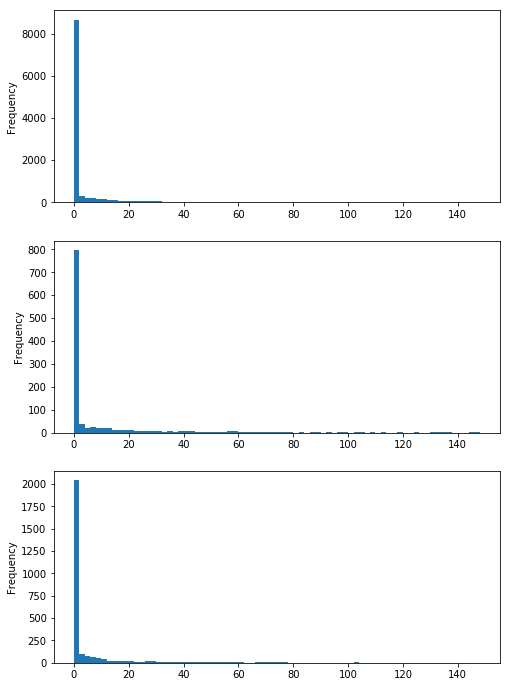

In [55]:
# decided to do delays instead of cancellations in keeping with the theme....
plt.figure(figsize=(8,12))

plt.subplot(311)
DCA.DEP_DELAY_NEW.plot(kind='hist', bins=range(0, 150, 2))
plt.subplot(312)
IAD.DEP_DELAY_NEW.plot(kind='hist', bins=range(0, 150, 2))
plt.subplot(313)
BWI.DEP_DELAY_NEW.plot(kind='hist', bins=range(0, 150, 2))



In [102]:
def central_limit_theorem_plotter(distribution, sample_size, num_samples):
    sample_means = np.zeros(num_samples)
    pop_std = distribution.std()
    for idx, num in enumerate(range(num_samples)):
        sample = np.random.choice(distribution, size=sample_size, replace=True)
        sample_means[idx] = sample.mean()
    return sample_means

In [117]:
DCA_s = central_limit_theorem_plotter(DCA.DEP_DELAY_NEW, 100, 1000)
IAD_s = central_limit_theorem_plotter(IAD.DEP_DELAY_NEW, 100, 1000)
BWI_s = central_limit_theorem_plotter(BWI.DEP_DELAY_NEW, 100, 1000)

Check for homoscedasticity  - This appears to fail levene test for equal variance.  Bah.  Looks like we can't assume that.

will use Kruskal-Wallis H-test instead - this is non parametric version of one-way anova test.  

In [122]:
stats.levene(DCA_s, IAD_s, BWI_s)

LeveneResult(statistic=64.06413411416847, pvalue=5.696592259087258e-28)

In [123]:
stats.kruskal(DCA_s, IAD_s, BWI_s)

KruskalResult(statistic=201.19728630038023, pvalue=2.0443930360411066e-44)

Post-hoc methods - Tukey's Test

In [ ]:
mc = MultiComparison(, )
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)